# Library

In [191]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

import webbrowser
webbrowser.open('https://piratelol.ytmnd.com/') #watch out if you are epileptic
from text_unidecode import unidecode
from tqdm.notebook import tqdm 
tqdm.pandas()
#if u are using IDE (eg., visual studio, spyder ...) that aren't jupyter notebook just import tqdm and avoid tqdm.pandas()
import warnings
warnings.filterwarnings("ignore") #I hate red/pink (salmon?) message 
pd.set_option('display.max_columns', None) #to visualize all the columns of the dataframe


True

# Functions 

(it would be best if they were within a .py file that you import as a library)

In [192]:
def extract_mentions(text): #don't forget to import re!
    # Define the regular expression pattern for mentions
    pattern = r"@\w+"
    # Use the findall method to get all matches
    mentions = re.findall(pattern, text)
    return mentions

def extract_hashtags(text): 
    # Define the regular expression pattern for mentions
    pattern = r"#\w+"
    hashtags = re.findall(pattern, text)
    return hashtags

def translation_Transformer(row):
    if row['label'] !='en':
        return translator(row['text'])[0]['translation_text']
    else:
        return row['text']


def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub('', text)


def filter_labels_by_score(text):
    output = classifier(text, candidate_labels, multi_label=False)
    filtered_labels = [label for label, score in zip(output['labels'], output['scores']) if score > 0.4]
    
    if not filtered_labels:
        return None  # or return an empty list []
    
    return filtered_labels


In [193]:
df = pd.read_csv('https://raw.githubusercontent.com/DSS-ML/Transformer/main/Challenge/data_tweet_sample_challenge.csv')

In [194]:
df = df[['id','created_at','text','author.id','author.name','public_metrics.like_count','public_metrics.retweet_count',
   'label']]

# Pre Processing on text

Extract info

In [195]:
#first extract all the mentions '@'
df['mentions'] = df['text'].progress_apply(lambda x: extract_mentions(x))
df['mentions']

  0%|          | 0/3000 [00:00<?, ?it/s]

0       [@GameCentral, @2K]
1                        []
2                        []
3           [@mw_buchenau_]
4                        []
               ...         
2995                     []
2996                     []
2997                     []
2998          [@welt, @N24]
2999     [@MirrorWeirdNews]
Name: mentions, Length: 3000, dtype: object

In [196]:
df['hashtags'] = df['text'].progress_apply(lambda x: [i.lower() for i in extract_hashtags(x)])
df['hashtags']

  0%|          | 0/3000 [00:00<?, ?it/s]

0                                                      []
1                                                      []
2       [#ciencia, #neardental, #denisovano, #intelige...
3                               [#porsche, #handelsblatt]
4                                                      []
                              ...                        
2995                                                   []
2996                                                   []
2997                                                   []
2998                              [#360video, #etna, #vr]
2999                                                   []
Name: hashtags, Length: 3000, dtype: object

Remove RT from text

In [197]:
df['text_clean'] = df['text'].progress_apply(lambda x : x.replace("RT", "").strip())
df['text_clean']

  0%|          | 0/3000 [00:00<?, ?it/s]

0       @GameCentral: Borderlands 2 VR and it's rough ...
1       This is 'the world’s sexiest robot’... apparen...
2       Un antepasado del que no sabíamos nada 👴👵 #cie...
3       Im neuen #Porsche "Mission E" steckt die Block...
4       Tweede Wereldoorlog in virtual reality herbele...
                              ...                        
2995    Robi, ecco il robot   fai-da-te | Video http:/...
2996    Robot sex brothel 'teaches men to be rapists' ...
2997    Renzi a Pisa, tra selfie e strette di mano "ro...
2998    Mit Turnschuhen... Wie ich einmal den Ätna bes...
2999    @MirrorWeirdNews: This robot is the first to E...
Name: text_clean, Length: 3000, dtype: object

let's check if some text are equal <-<

In [198]:
df['text_clean'].drop_duplicates() #yes D: 

0       @GameCentral: Borderlands 2 VR and it's rough ...
1       This is 'the world’s sexiest robot’... apparen...
2       Un antepasado del que no sabíamos nada 👴👵 #cie...
3       Im neuen #Porsche "Mission E" steckt die Block...
4       Tweede Wereldoorlog in virtual reality herbele...
                              ...                        
2995    Robi, ecco il robot   fai-da-te | Video http:/...
2996    Robot sex brothel 'teaches men to be rapists' ...
2997    Renzi a Pisa, tra selfie e strette di mano "ro...
2998    Mit Turnschuhen... Wie ich einmal den Ätna bes...
2999    @MirrorWeirdNews: This robot is the first to E...
Name: text_clean, Length: 2996, dtype: object

It is therefore necessary to construct a retweet variable that identifies whether a tweet is original or not 

In [199]:
df['is_retweet'] = df['text'].str.startswith('RT') #573 True
df['is_retweet'].value_counts(normalize = True) #19%

False    0.809
True     0.191
Name: is_retweet, dtype: float64

Translation
- check how many tweets aren't in english [a]
- use lang detect tool to do it (sloooooower) [b]

In [200]:
#a
df['label'].value_counts(), df['label'].value_counts()[1:].sum() #2250

(en    750
 fr    738
 it    656
 es    466
 de    219
 nl    171
 Name: label, dtype: int64,
 2250)

In [76]:
#b
detect = pipeline (model ="papluca/xlm-roberta-base-language-detection")
df['label_Transformer'] = df['text'].progress_apply(lambda x: detect(x)[0]['label'])

  0%|          | 0/3000 [00:00<?, ?it/s]

In [79]:
#let's check for how many there is a problem in the label... or even if the tweet is from another country it is still in English 
df.query('label_Transformer != label')[['label_Transformer','label']]
#not so much and since the model is not perfect accurate i'll prefer keep using label one :D

,label_Transformer,label
29,hi,en
39,it,nl
44,en,fr
120,en,de
123,en,de
...,...,...
2914,nl,en
2919,sw,en
2931,en,fr
2949,sw,en


In [202]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-mul-en") #multi-language (mul)
#methods above

df['en_text'] = df.progress_apply(lambda x: translation_Transformer(x), axis=1) #42 minutes

  0%|          | 0/3000 [00:00<?, ?it/s]

remove url and RT

In [203]:
df['en_text_clean'] = df['en_text'].progress_apply(lambda x: remove_urls(x).strip())
df['en_text_clean'] = df['en_text_clean'].str.replace('RT','').str.strip()

  0%|          | 0/3000 [00:00<?, ?it/s]

In [204]:
df['created_at_M'] = df['created_at'].apply(lambda x: x[:7]) 
df['created_at_M'] = pd.to_datetime(df['created_at_M'])

# Data Exploration

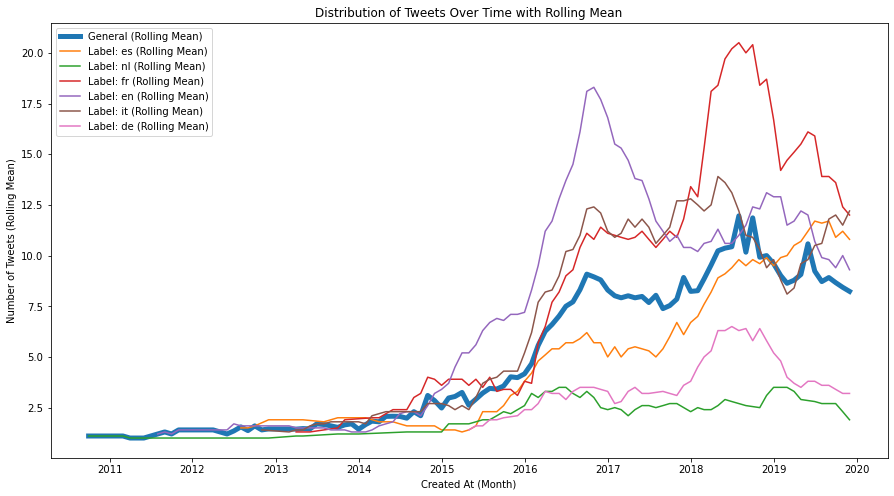

In [137]:
agg_df = df.groupby(['created_at_M', 'label']).agg({'id': 'count'}).reset_index()
window_size = 10 #Replace with an appropriate window size
agg_df['rolling_mean'] = agg_df.groupby('label')['id'].transform(lambda x: x.rolling(window=window_size).mean())

plt.figure(figsize=(15, 8))  #Increase the size of the plot

#General distribution with rolling mean
sns.lineplot(x='created_at_M', y='rolling_mean', data=agg_df, label='General (Rolling Mean)', ci =None, linewidth=5)

#Distribution per label with rolling mean
for label in agg_df['label'].unique():
    subset = agg_df[agg_df['label'] == label]
    sns.lineplot(x='created_at_M', y='rolling_mean', data=subset, label=f'Label: {label} (Rolling Mean)', ci=None)

plt.xlabel('Created At (Month)')
plt.ylabel('Number of Tweets (Rolling Mean)')
plt.title('Distribution of Tweets Over Time with Rolling Mean')
plt.legend()
plt.show()

# uk https://www.gov.uk/government/publications/national-ai-strategy 2016/2017
# fr https://www.inria.fr/en/french-national-artificial-intelligence-research-program 2018

In [165]:
# Group by 'label' and 'author.name' and count the occurrences
grouped_df = df.groupby(['label', 'author.name']).size().reset_index(name='count')

# Sort within each label and get the top 5
top_authors_per_label = grouped_df.groupby('label').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Initialize an empty dictionary to store the top authors and their counts for each country
top_authors_count_dict = {}

# Loop through each unique label (country code)
for country in top_authors_per_label['label'].unique():
    # Extract the subset for the current country
    subset = top_authors_per_label[top_authors_per_label['label'] == country]
    
    # Create a list of tuples (author_name, count)
    author_count_list = list(zip(subset['author.name'], subset['count']))
    
    # Add this list to the dictionary with the country code as the key
    top_authors_count_dict[country] = author_count_list

# Convert the dictionary to a DataFrame
final_df_with_count = pd.DataFrame.from_dict(top_authors_count_dict, orient='index').transpose()

final_df_with_count.rename(columns = {'de':'🚬🧻','en':'🇬🇧','es':'🇪🇸','fr':'🥖','it':'🍕','nl':'🇳🇱'})


,🚬🧻,🇬🇧,🇪🇸,🥖,🍕,🇳🇱
0,"(Handelsblatt, 59)","(The Mirror, 147)","(La Vanguardia, 104)","(Les Echos, 239)","(Repubblica, 212)","(de Volkskrant, 44)"
1,"(WELT, 37)","(The Guardian, 142)","(EL PAÍS, 70)","(Le Figaro, 146)","(La Stampa, 166)","(De Telegraaf, 35)"
2,"(Martin Heller, 18)","(Daily Mail Online, 95)","(ABC.es, 62)","(Le Monde, 68)","(Corriere della Sera, 101)","(NRC, 26)"
3,"(Felix Holtermann, 12)","(The Sun, 81)","(La Razón, 58)","(Le Parisien, 45)","(Quotidiano Libero, 18)","(De Stentor, 19)"
4,"(Frankfurter Allgemeine, 10)","(Mirror Tech, 64)","(El Periódico, 44)","(l'Opinion, 36)","(Repubblica Tecnologia, 18)","(Trouw, 10)"


In [138]:
df['mentions'].explode().value_counts()[:5] 
#since mentions column is a list, with explode is possible to unlist every row and count the values

@MirrorTech       67
@LaStampa         57
@welt             46
@Le_Figaro        27
@BigBangFigaro    26
Name: mentions, dtype: int64

In [201]:
# Group by 'label' and 'author.name' and count the occurrences
grouped_df = df.explode('hashtags').groupby(['label', 'hashtags']).size().reset_index(name='count')

# Sort within each label and get the top 5
top_authors_per_label = grouped_df.groupby('label').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Initialize an empty dictionary to store the top authors and their counts for each country
top_authors_count_dict = {}

# Loop through each unique label (country code)
for country in top_authors_per_label['label'].unique():
    # Extract the subset for the current country
    subset = top_authors_per_label[top_authors_per_label['label'] == country]
    
    # Create a list of tuples (author_name, count)
    hashtags_count_list = list(zip(subset['hashtags'], subset['count']))
    
    # Add this list to the dictionary with the country code as the key
    top_authors_count_dict[country] = hashtags_count_list

# Convert the dictionary to a DataFrame
final_df_with_count = pd.DataFrame.from_dict(top_authors_count_dict, orient='index').transpose()

final_df_with_count.rename(columns = {'de':'🚬🧻','en':'🇬🇧','es':'🇪🇸','fr':'🥖','it':'🍕','nl':'🇳🇱'})


,🚬🧻,🇬🇧,🇪🇸,🥖,🍕,🇳🇱
0,"(#blockchain, 38)","(#ces2017, 2)","(#tecnología, 19)","(#ia, 29)","(#robot, 13)","(#robot, 4)"
1,"(#vr, 36)","(#futureofeverything, 2)","(#inteligenciaartificial, 10)","(#bigbangeco, 25)","(#webnotte, 7)","(#techblog, 2)"
2,"(#handelsblatt, 21)","(#arsnew, 1)","(#innovadores, 5)","(#intelligenceartificielle, 21)","(#onlife19, 5)","(#volkskrantgeluid, 2)"
3,"(#virtualreality, 19)","(#bustertheboxer, 1)","(#ciencia, 3)","(#iot, 15)","(#italiadigitale, 4)","(#ai, 1)"
4,"(#360video, 17)","(#ces2016, 1)","(#barcelona, 2)","(#blockchain, 14)","(#fqmillennium, 3)","(#atlas, 1)"


# Data Analysis

## sentiment analysis
### a) original text


In [209]:
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
df['sentiment_original'] = df['text'].progress_apply(lambda x:sentiment_task(x)[0]['label'])#1.36 minutes



  0%|          | 0/3000 [00:00<?, ?it/s]

### b) english text

In [210]:
#same model
df['sentiment_en'] = df['text'].progress_apply(lambda x : sentiment_task(x)[0]['label'])

  0%|          | 0/3000 [00:00<?, ?it/s]

### check the difference, if there are ...

In [211]:
df.query('sentiment_original!=sentiment_en') # no :)

,id,created_at,text,author.id,author.name,public_metrics.like_count,public_metrics.retweet_count,label,mentions,hashtags,text_clean,is_retweet,en_text,en_text_clean,created_at_M,sentiment_original,sentiment_en


### Results of Sentiment

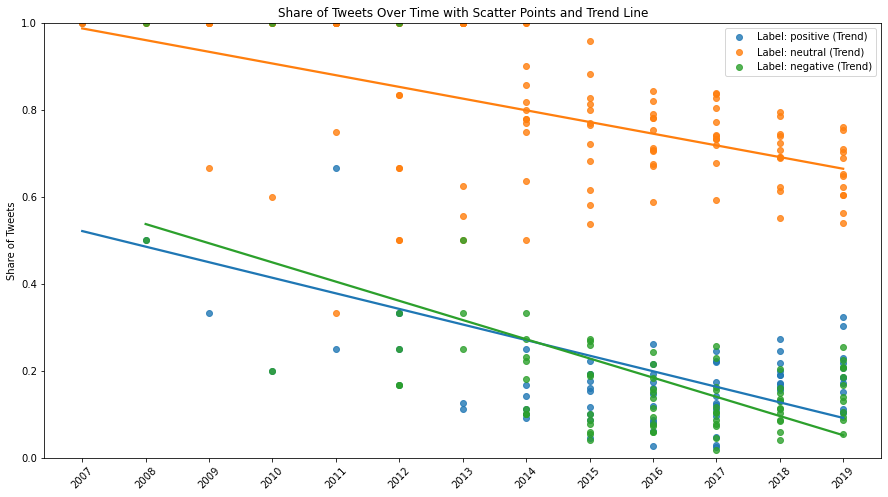

In [230]:

#Calculate the total number of tweets for each time period
total_counts = df.groupby('created_at_M').agg({'id': 'count'}).reset_index()
total_counts = total_counts.rename(columns={'id': 'total_count'})

#Calculate the number of tweets for each label and time period
agg_df = df.groupby(['created_at_M', 'sentiment_en']).agg({'id': 'count'}).reset_index()

#Merge to get total counts in each row
agg_df = pd.merge(agg_df, total_counts, on='created_at_M')

#Calculate the share of each label for each time period
agg_df['share'] = agg_df['id'] / agg_df['total_count']

#Convert Timestamp to numerical values for plotting
agg_df['created_at_M_num'] = (agg_df['created_at_M'].dt.to_period('Y') - agg_df['created_at_M'].min().to_period('Y')).apply(lambda x: x.n)

plt.figure(figsize=(15, 8))  

for label in agg_df['sentiment_en'].unique():
    subset = agg_df[agg_df['sentiment_en'] == label]
        
    # Trend Line (Linear Fit)
    sns.regplot(x='created_at_M_num', y='share', data=subset, scatter=True, label=f'Label: {label} (Trend)', ci=None)

#Setting x-ticks to represent actual years
xticks = agg_df['created_at_M_num'].unique()
xticklabels = agg_df['created_at_M'].dt.to_period('Y').astype(str).unique()
plt.xticks(xticks, xticklabels, rotation=45)

plt.xlabel('')
plt.ylabel('Share of Tweets')
plt.ylim(0, 1)  #Set y-axis limits to be between 0 and 1
plt.title('Share of Tweets Over Time with Scatter Points and Trend Line')
plt.legend()
plt.show()


## NER

In [242]:
tokenizer = AutoTokenizer.from_pretrained("Davlan/distilbert-base-multilingual-cased-ner-hrl")
model = AutoModelForTokenClassification.from_pretrained("Davlan/distilbert-base-multilingual-cased-ner-hrl")
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

df['ner'] = df['en_text'].progress_apply(lambda x: [i['word'] for i in nlp(x) if i['entity'] in ['B-LOC', 'I-LOC']])

  0%|          | 0/3000 [00:00<?, ?it/s]

## Zero shot classification

In [251]:
# https://www.nature.com/articles/s42256-019-0020-9

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")
sequence_to_classify = "Angela Merkel is a politician in Germany and leader of the CDU"
candidate_labels = ["Health", "Employment", "Privacy", "Environment"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)


{'sequence': 'Angela Merkel is a politician in Germany and leader of the CDU', 'labels': ['Employment', 'Privacy', 'Health', 'Environment'], 'scores': [0.4715060889720917, 0.26406651735305786, 0.15532250702381134, 0.10910487174987793]}


In [261]:
    
df['zero_shot_en'] = df['en_text'].progress_apply(lambda x: filter_labels_by_score(x)) #20 minutes


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [20:17<00:00,  2.46it/s]


In [265]:
grouped_df = df.explode('zero_shot_en').groupby(['label', 'zero_shot_en']).size().reset_index(name='count')

top_authors_per_label = grouped_df.groupby('label').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

top_authors_count_dict = {}

for country in top_authors_per_label['label'].unique():
    subset = top_authors_per_label[top_authors_per_label['label'] == country]
    
    zero_shot_en_count_list = list(zip(subset['zero_shot_en'], subset['count']))
    
    top_authors_count_dict[country] = zero_shot_en_count_list

final_df_with_count = pd.DataFrame.from_dict(top_authors_count_dict, orient='index').transpose()

final_df_with_count.rename(columns = {'de':'🚬🧻','en':'🇬🇧','es':'🇪🇸','fr':'🥖','it':'🍕','nl':'🇳🇱'})


,🚬🧻,🇬🇧,🇪🇸,🥖,🍕,🇳🇱
0,"(Employment, 44)","(Employment, 169)","(Employment, 84)","(Employment, 165)","(Employment, 175)","(Employment, 31)"
1,"(Environment, 31)","(Privacy, 130)","(Privacy, 66)","(Environment, 95)","(Privacy, 78)","(Privacy, 23)"
2,"(Privacy, 29)","(Environment, 72)","(Environment, 59)","(Privacy, 77)","(Environment, 71)","(Environment, 21)"
3,"(Health, 7)","(Health, 51)","(Health, 31)","(Health, 45)","(Health, 23)","(Health, 10)"


For example, let's see the sentiment over time for the employement topic by comparing by country

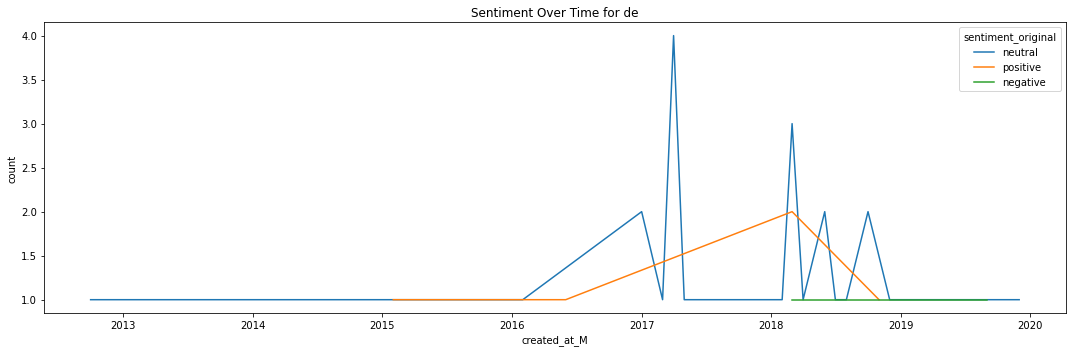

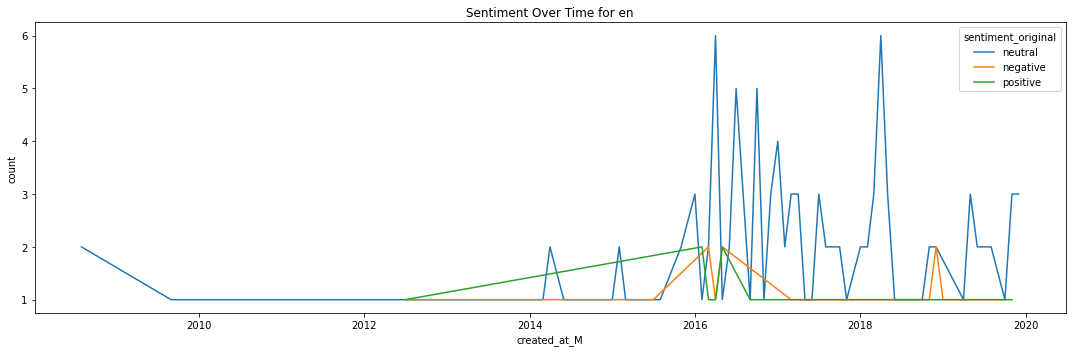

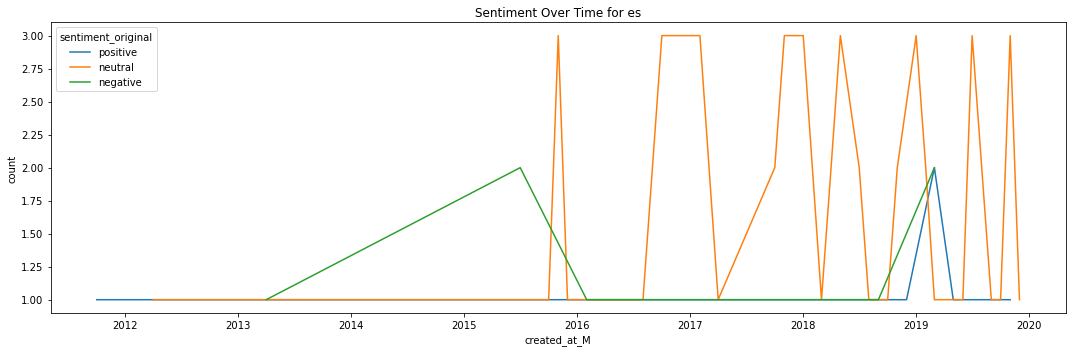

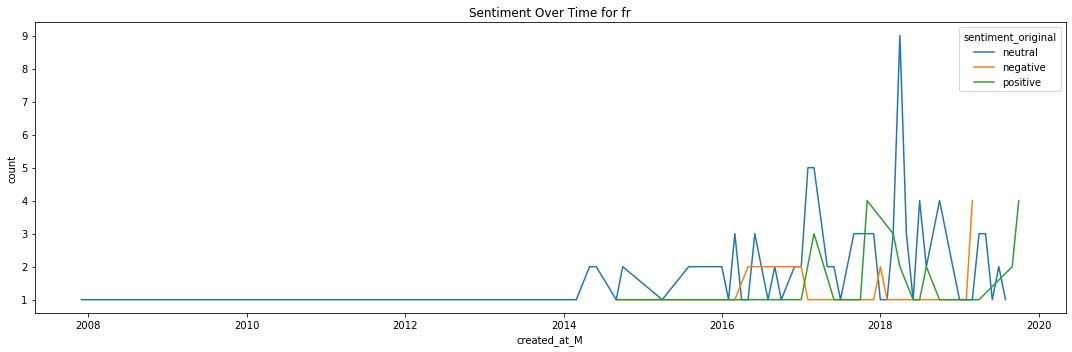

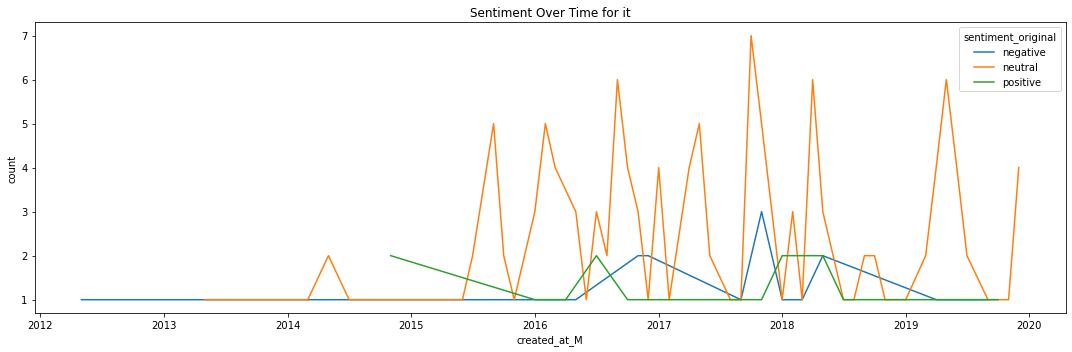

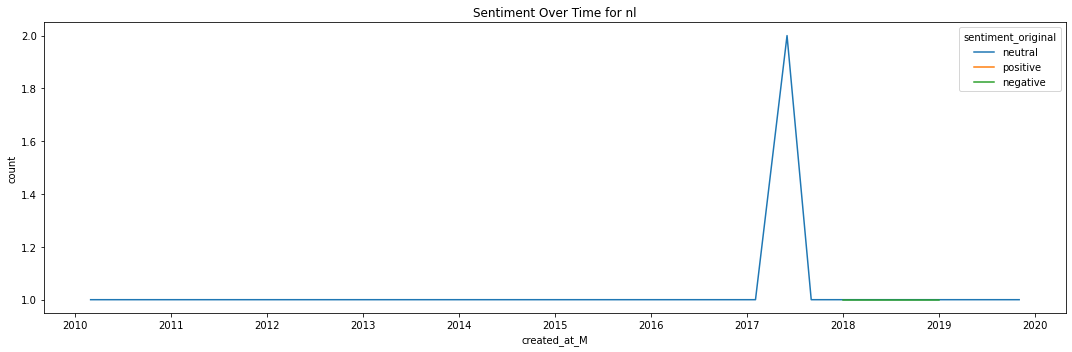

In [288]:
df_filtered = df[df['zero_shot_en'].apply(lambda x: 'Employment' in x if x is not None else False)]
df_grouped = df_filtered.groupby(['label', 'created_at_M', 'sentiment_original']).size().reset_index(name='count')
countries = df_grouped['label'].unique()
for country in countries:
    df_country = df_grouped[df_grouped['label'] == country]
    
    plt.figure(figsize=(15, 5))
    
    sns.lineplot(x='created_at_M', y='count', hue='sentiment_original', data=df_country)
    plt.title(f"Sentiment Over Time for {country}")
    
    plt.tight_layout()
    plt.show()

